In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Verzeichnis der CSV-Dateien
ids17_prep_0 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_0'
ids18_prep_0 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_0'
hybrid_prep_0 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_0'

## Datensätze laden

In [72]:
df_ids17 = pd.read_parquet(ids17_prep_0)
df_ids18 = pd.read_parquet(ids18_prep_0)
df_hybrid = pd.read_parquet(hybrid_prep_0)

## Klassenübersichten anzeigen

In [73]:
# Entferne nicht verwendete Kategorien aus der 'Label'-Spalte in ids18
df_ids18['Label'] = df_ids18['Label'].cat.remove_unused_categories()

In [90]:
df_ids18['Label'].value_counts()

Label
BENIGN                          2967676
DoS Hulk                        1803160
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64

In [91]:
df_ids17['Label'].value_counts()


Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64

In [92]:
df_hybrid['Label'].value_counts()


Label
DoS Hulk                        1961628
BENIGN                          1582561
DDoS-LOIC-HTTP                   384472
Infiltration - NMAP Portscan     161141
Botnet Ares                      143657
SSH-BruteForce                    97158
DoS GoldenEye                     30127
DoS Slowloris                     12349
Name: count, dtype: int64

## Feature Selection

### Random Forest Classifier

In [77]:
# Lade den Datensatz, nutze ids18 für die Auswahl der Features
data = df_ids18

# Features und Zielvariable trennen
X = data.drop('Label', axis=1)
y = data['Label']

# Random Forest trainieren
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature Importances extrahieren
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [78]:
# Wichtigste Features ausgeben
print(feature_importance_df.head(30))

                       feature  importance
68          FWD Init Win Bytes    0.100467
71            Fwd Seg Size Min    0.076927
14       Bwd Packet Length Std    0.047663
11       Bwd Packet Length Max    0.046108
42           Packet Length Max    0.042336
0                     Dst Port    0.036913
69          Bwd Init Win Bytes    0.033884
10       Fwd Packet Length Std    0.031761
13      Bwd Packet Length Mean    0.031375
57        Bwd Segment Size Avg    0.030755
25                 Fwd IAT Min    0.029840
46              FIN Flag Count    0.029740
7        Fwd Packet Length Max    0.027361
6   Total Length of Bwd Packet    0.026961
20                Flow IAT Min    0.024023
67           Subflow Bwd Bytes    0.021060
4            Total Bwd packets    0.020155
32               Bwd PSH Flags    0.018209
26               Bwd IAT Total    0.017879
55         Average Packet Size    0.017288
38           Bwd Header Length    0.017168
45      Packet Length Variance    0.017146
5   Total L

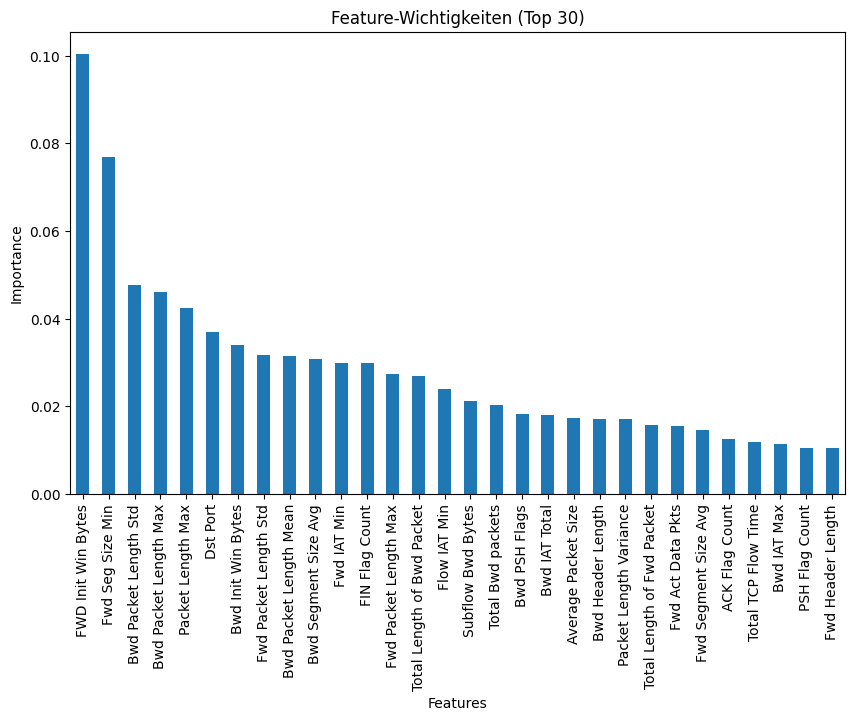

In [80]:
# Balkendiagramm der Feature-Wichtigkeiten
feature_importance_df.head(30).plot(
    x='feature', y='importance', kind='bar', legend=False, figsize=(10, 6)
)
plt.title('Feature-Wichtigkeiten (Top 30)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

### Korrelationsmatrix

In [81]:
# Korrelationsmatrix berechnen
correlation_matrix = X.corr()

# Features mit hoher Korrelation finden
threshold = 0.9
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print('Features mit hoher Korrelation:', high_corr_features)

Features mit hoher Korrelation: {'Subflow Bwd Bytes', 'Bwd Segment Size Avg', 'ACK Flag Count', 'Bwd Packet/Bulk Avg', 'Total Length of Bwd Packet', 'Idle Max', 'Fwd Bytes/Bulk Avg', 'Fwd IAT Max', 'PSH Flag Count', 'Fwd Packets/s', 'Fwd Segment Size Avg', 'Flow IAT Max', 'Idle Min', 'Fwd Packet/Bulk Avg', 'Packet Length Min', 'Subflow Fwd Bytes', 'Packet Length Std', 'Fwd Packet Length Std', 'Packet Length Variance', 'Active Max', 'Bwd Packet Length Std', 'Packet Length Max', 'Bwd IAT Total', 'URG Flag Count', 'ECE Flag Count', 'Idle Mean', 'Average Packet Size', 'Bwd Packets/s', 'Bwd IAT Max', 'Active Min'}


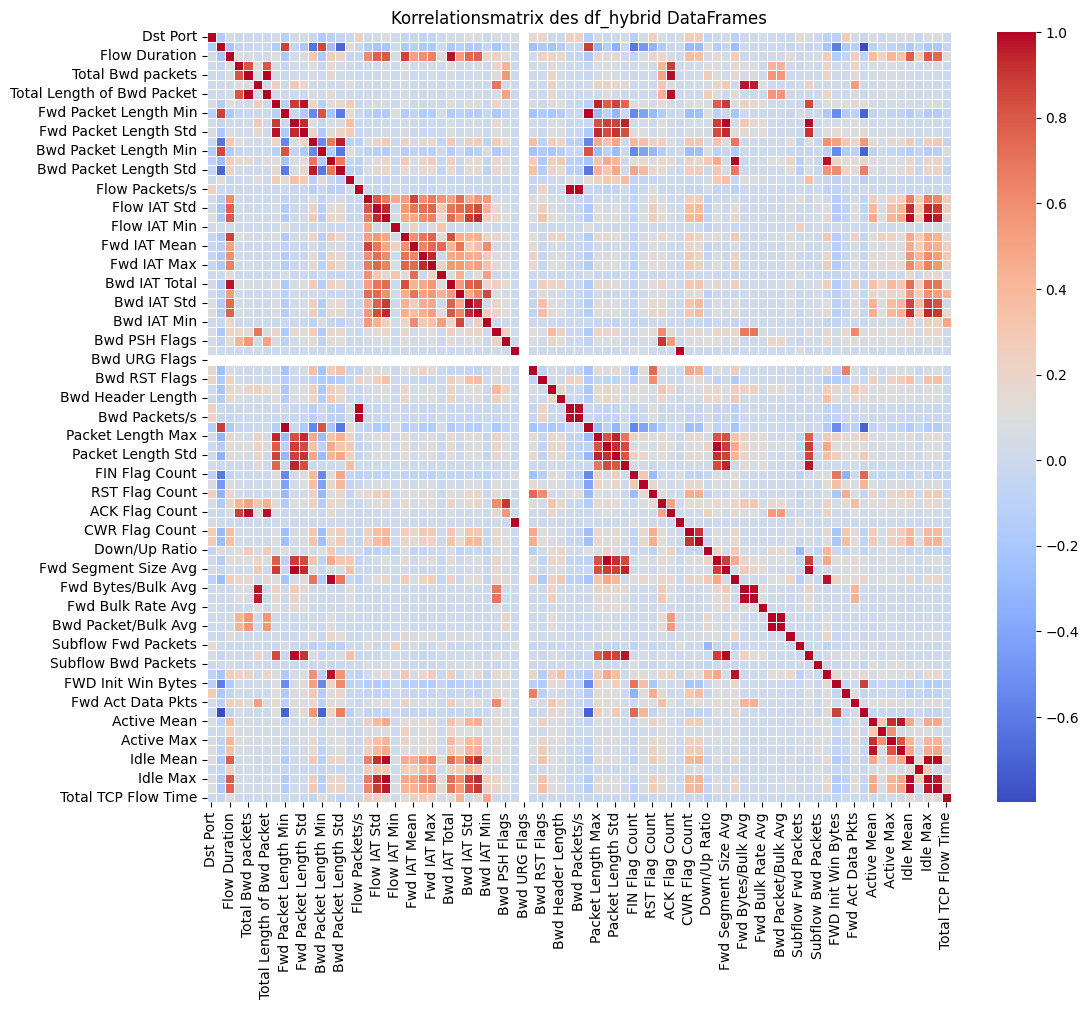

In [ ]:
# Größe der Grafik 
plt.figure(figsize=(12, 10))

# Heatmap erstellen
sns.heatmap(correlation_matrix, 
            annot=False,        # Korrelationskoeffizienten anzeigen
            fmt=".2f",         # Format der Koeffizienten
            cmap="coolwarm",   # Farbschema der Heatmap
            linewidths=0.5)    # Linien zwischen den Zellen

# Titel hinzufügen (optional)
plt.title("Korrelationsmatrix")

# Grafik anzeigen
plt.show()

In [83]:
# Finde stark korrelierte Paare
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(pair)

# Liste der Paare anzeigen
for pair in high_corr_pairs:
    print(f"Stark korreliertes Paar: {pair}")


Stark korreliertes Paar: ('Total Length of Bwd Packet', 'Total Bwd packets')
Stark korreliertes Paar: ('Fwd Packet Length Std', 'Fwd Packet Length Max')
Stark korreliertes Paar: ('Fwd Packet Length Std', 'Fwd Packet Length Mean')
Stark korreliertes Paar: ('Bwd Packet Length Std', 'Bwd Packet Length Max')
Stark korreliertes Paar: ('Flow IAT Max', 'Flow IAT Std')
Stark korreliertes Paar: ('Fwd IAT Max', 'Fwd IAT Std')
Stark korreliertes Paar: ('Bwd IAT Total', 'Flow Duration')
Stark korreliertes Paar: ('Bwd IAT Max', 'Flow IAT Max')
Stark korreliertes Paar: ('Bwd IAT Max', 'Bwd IAT Std')
Stark korreliertes Paar: ('Fwd Packets/s', 'Flow Packets/s')
Stark korreliertes Paar: ('Bwd Packets/s', 'Flow Packets/s')
Stark korreliertes Paar: ('Bwd Packets/s', 'Fwd Packets/s')
Stark korreliertes Paar: ('Packet Length Min', 'Fwd Packet Length Min')
Stark korreliertes Paar: ('Packet Length Max', 'Fwd Packet Length Max')
Stark korreliertes Paar: ('Packet Length Max', 'Fwd Packet Length Std')
Stark kor

In [84]:
# Behalte von stark korrelierten Paaren das wichtigere Feature
features_to_keep = set(X.columns)  # Alle Features
for feature1, feature2 in high_corr_pairs:
    importance1 = feature_importance_df.loc[feature_importance_df['feature'] == feature1, 'importance'].values[0]
    importance2 = feature_importance_df.loc[feature_importance_df['feature'] == feature2, 'importance'].values[0]
    print(f"Feature1: {feature1}, Importance: {importance1}" + "vs." + f"Feature2: {feature2}, Importance: {importance2}")
    # Entferne das Feature mit der geringeren Importance
    if importance1 > importance2:
        features_to_keep.discard(feature2)
        print(f"Entferntes Feature: {feature2}")
    else:
        features_to_keep.discard(feature1)
        print(f"Entferntes Feature: {feature1}")

# Finaler reduzierter Datensatz
X_final = X[list(features_to_keep)]
print(f"Behaltene Features: {features_to_keep}")


Feature1: Total Length of Bwd Packet, Importance: 0.0269611773246881vs.Feature2: Total Bwd packets, Importance: 0.020155465710907077
Entferntes Feature: Total Bwd packets
Feature1: Fwd Packet Length Std, Importance: 0.031761281889610124vs.Feature2: Fwd Packet Length Max, Importance: 0.027361031741229856
Entferntes Feature: Fwd Packet Length Max
Feature1: Fwd Packet Length Std, Importance: 0.031761281889610124vs.Feature2: Fwd Packet Length Mean, Importance: 0.008459903068215525
Entferntes Feature: Fwd Packet Length Mean
Feature1: Bwd Packet Length Std, Importance: 0.04766268763227481vs.Feature2: Bwd Packet Length Max, Importance: 0.04610779878048039
Entferntes Feature: Bwd Packet Length Max
Feature1: Flow IAT Max, Importance: 0.007164918579417649vs.Feature2: Flow IAT Std, Importance: 0.0019073333374131519
Entferntes Feature: Flow IAT Std
Feature1: Fwd IAT Max, Importance: 0.005177565901464144vs.Feature2: Fwd IAT Std, Importance: 0.0036705570602156073
Entferntes Feature: Fwd IAT Std
Feat

In [85]:
X_final.shape

(5417706, 51)

### Korellationsmatrix nach Feature Selection

In [86]:
# Korrelationsmatrix berechnen
correlation_matrix = X_final.corr()

# Features mit hoher Korrelation finden
threshold = 0.9
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print('Features mit hoher Korrelation:', high_corr_features)

Features mit hoher Korrelation: set()


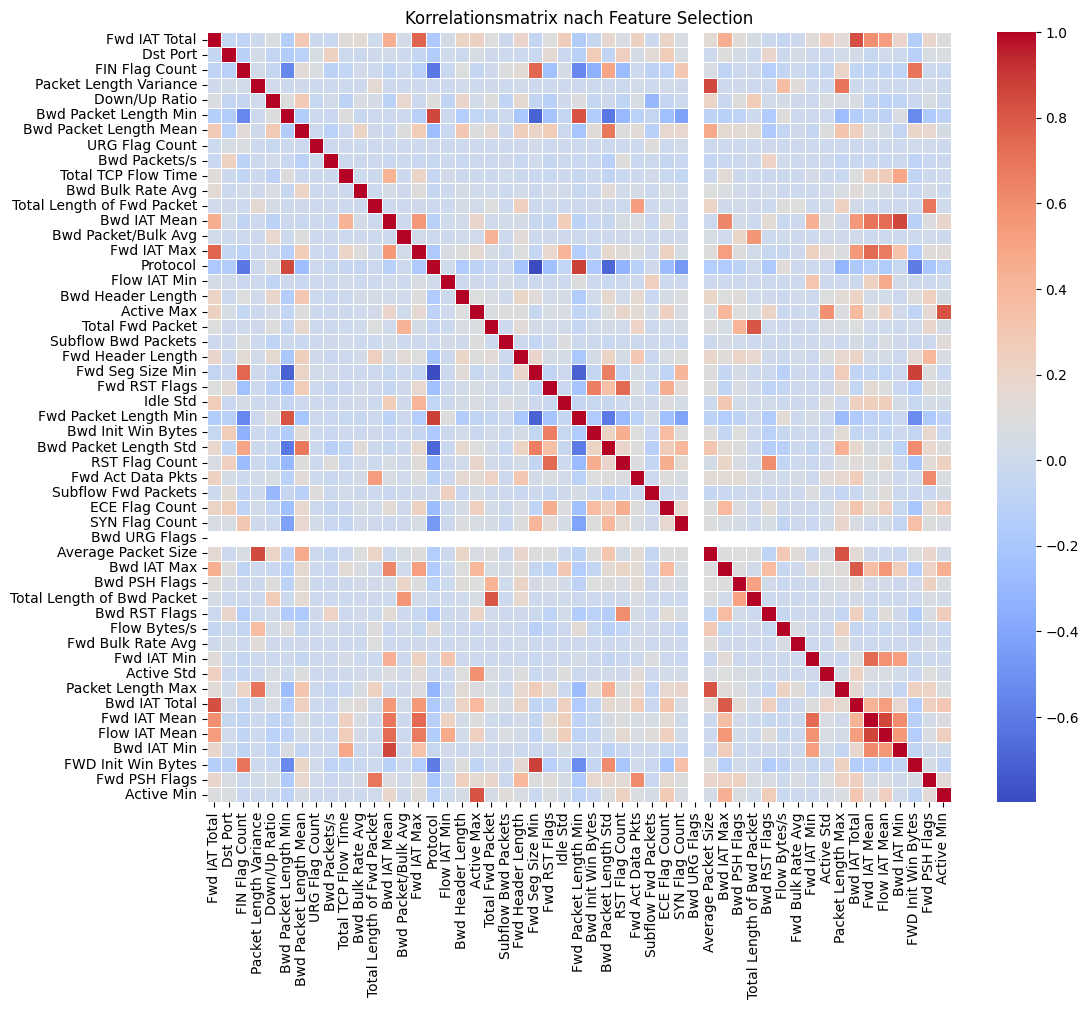

In [87]:
# Größe der Grafik 
plt.figure(figsize=(12, 10))

# Heatmap erstellen
sns.heatmap(correlation_matrix, 
            annot=False,        # Korrelationskoeffizienten anzeigen
            fmt=".2f",         # Format der Koeffizienten
            cmap="coolwarm",   # Farbschema der Heatmap
            linewidths=0.5)    # Linien zwischen den Zellen

# Titel hinzufügen (optional)
plt.title("Korrelationsmatrix nach Feature Selection")

# Grafik anzeigen
plt.show()

In [89]:
# Speichern der reduzierten Features
with open('22_reduced_features.txt', 'w') as f:
    for item in features_to_keep:
        f.write("%s\n" % item)